# Ajuste de salario

- **Autor:** Jeremy Comino Raigón
- **Curso:** Q1 2023-2024
- **Profesor:** Javier Béjar


In [ ]:
!pip install apafib

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import tensorflow as tf
from tensorflow import keras
from apafib import load_wages
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 3)


from scipy.stats import normaltest

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = load_wages()
df.head(5)
df.shape

,wage,educ,exper,fulltime,hrswk,nkids,age,married,female,insurance,private,mcaid,mcare,metro,northeast,midwest,south,west,white,black,asian
0,18.70,16,39,1,37,0,58,1,1,1,1,0,0,1,0,0,1,0,1,0,0
1,11.50,12,16,1,62,2,31,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,15.04,16,13,1,40,0,32,1,0,1,1,0,0,1,0,0,0,1,0,1,0
3,25.95,14,11,1,40,3,29,0,1,1,1,0,0,1,0,0,1,0,0,1,0
4,24.03,12,51,1,40,0,66,1,0,1,1,0,0,1,1,0,0,0,1,0,0


(4838, 21)

Tenemos un dataset de 4838 ejemplares y 21 atributos. A continuación haremos la separación en conjunto de test y entrenamiento, concretamente 30% de las instancias serán test y 70% entrenamiento.

In [ ]:
Train, Test = train_test_split(df, random_state=0, test_size= 0.3)

##Estudio univariable

Primero de todo veremos las diferentes distribuciones que llegan a presentar las diferentes variables.

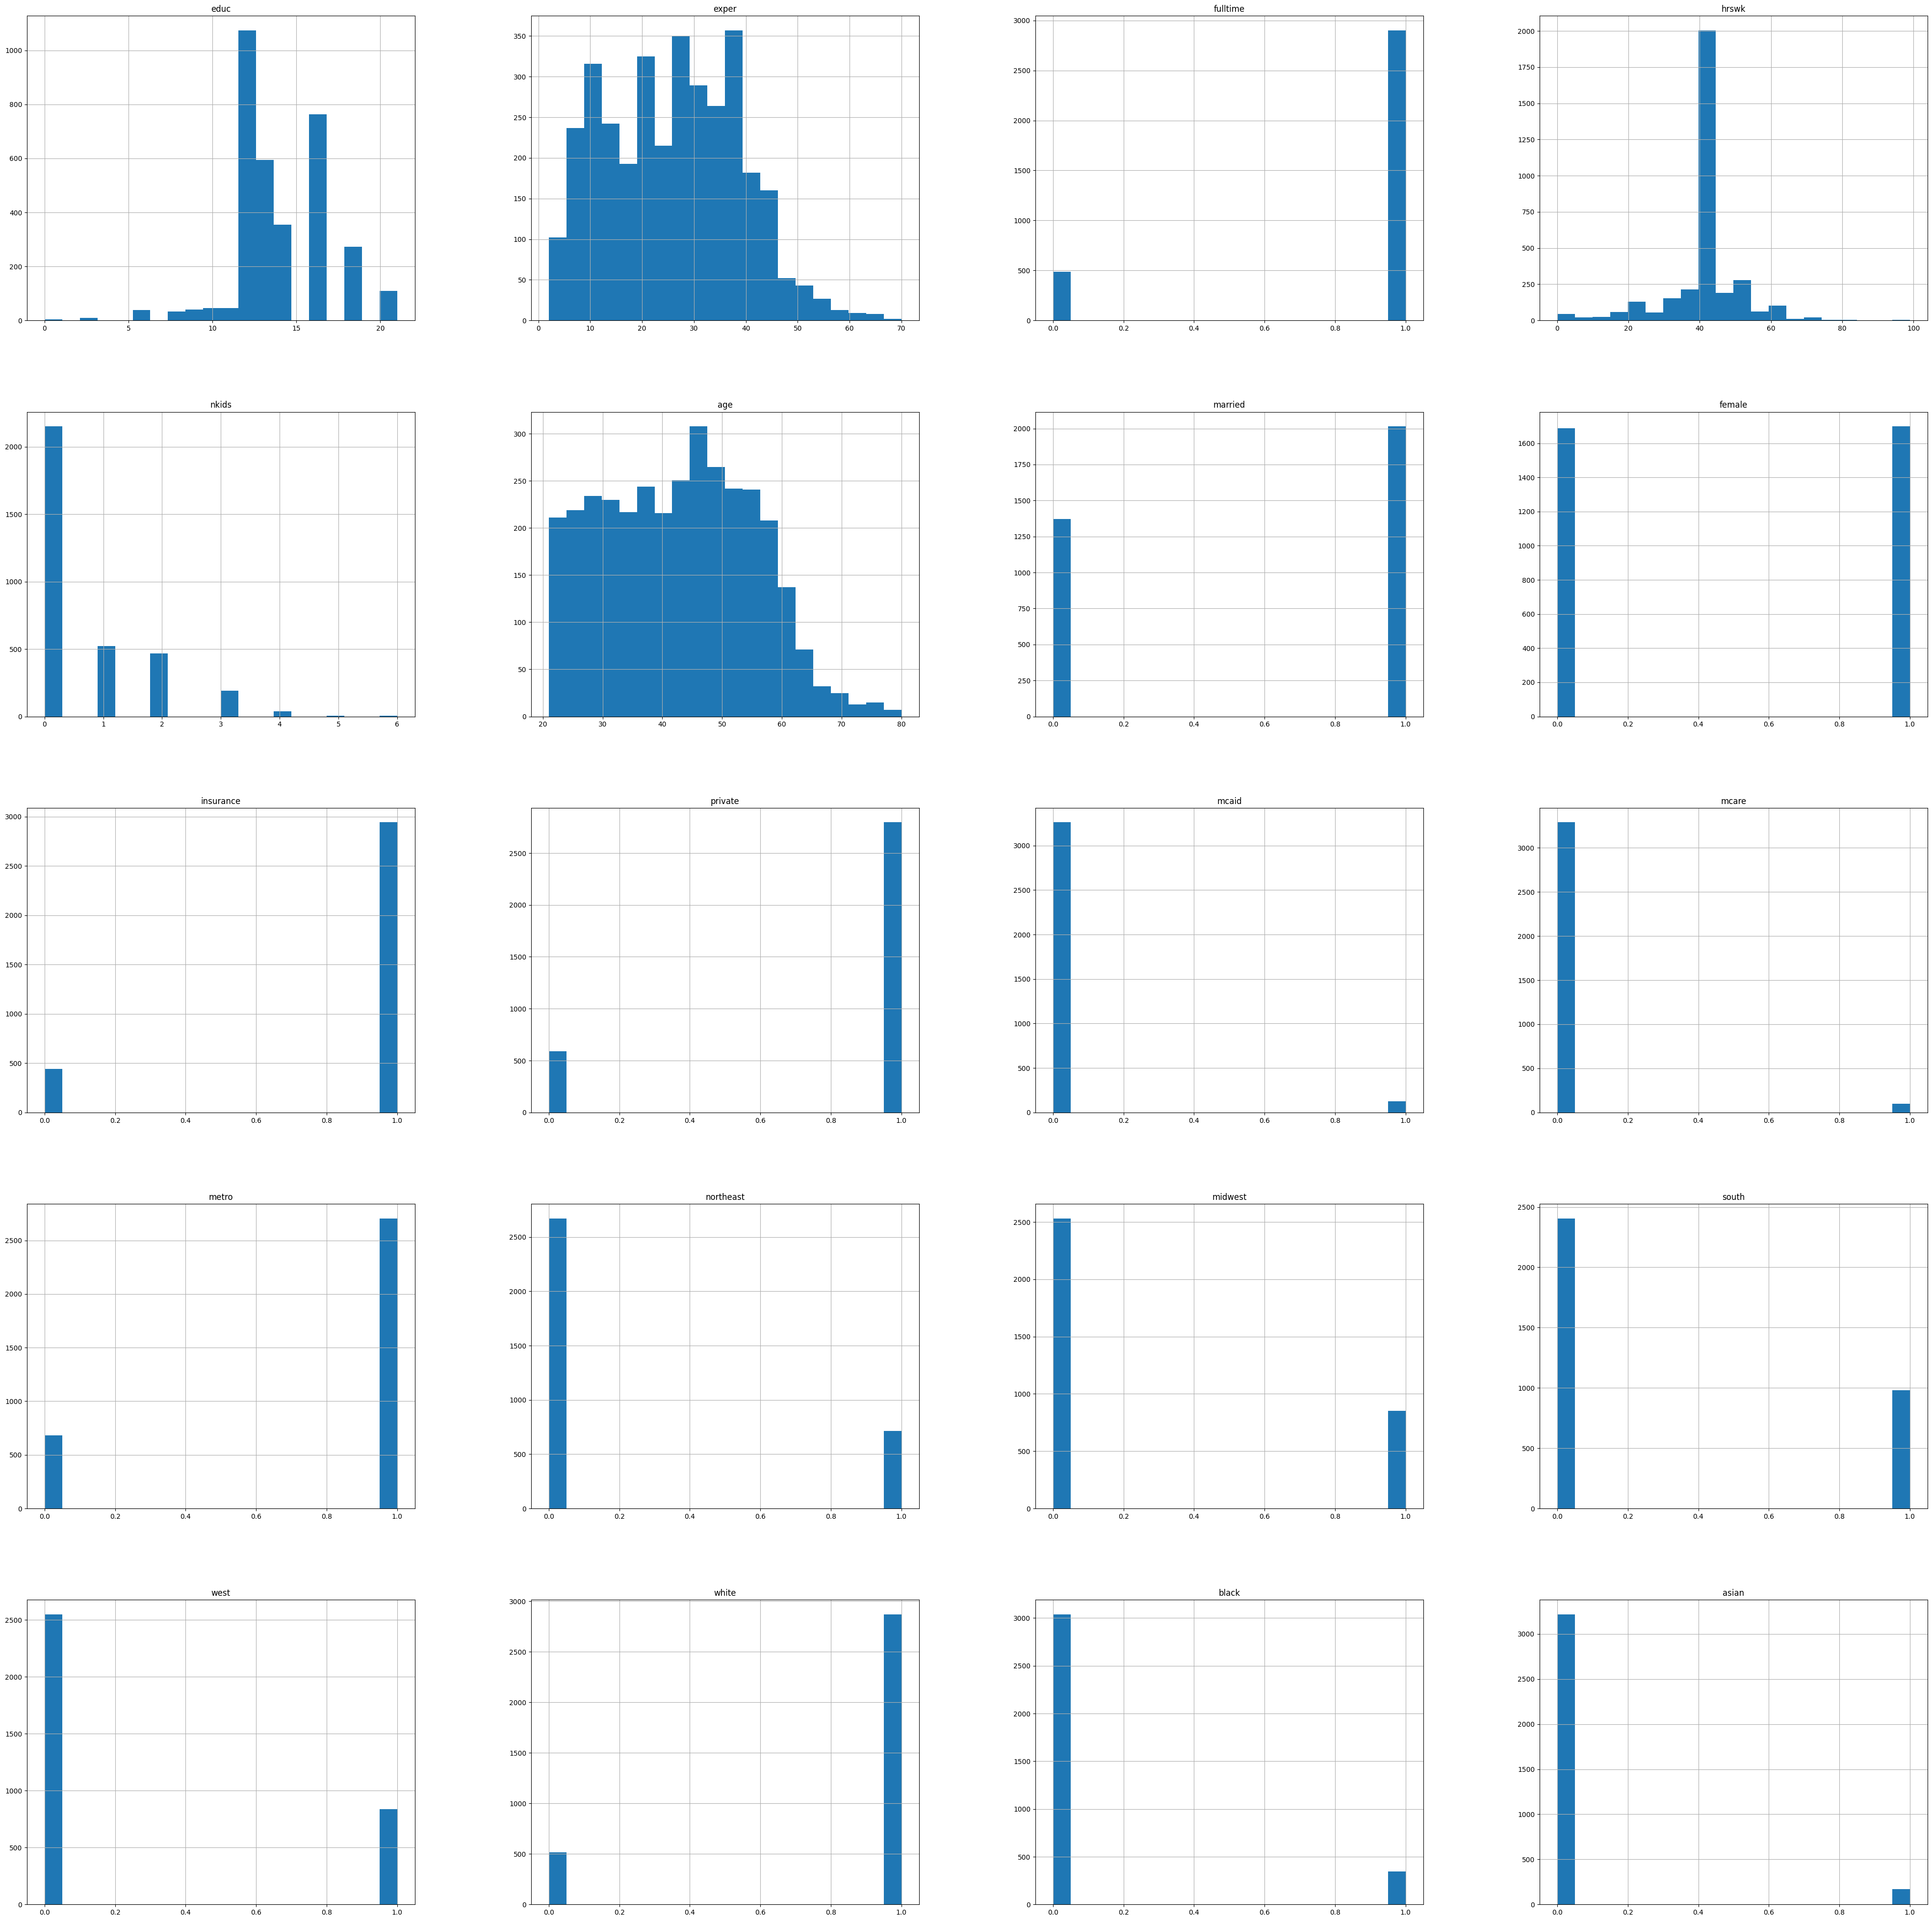

In [ ]:
_=Train.iloc[:,1:].hist(bins=20, figsize=(50,50))

Podemos ver 5 variables no categorícas. Donde a primeras, vemos que no siguen una distribución gaussiana. También podemos observar que la variable *nkids* puede seguir una distribución exponencial. A continuación un estudio bivariable con el objetivo de poder llegar a eliminar variables que se pueden llegar a explicar con otras.

##Estudio bivariable


(<Figure size 1000x800 with 1 Axes>, <Axes: >)

<Axes: >

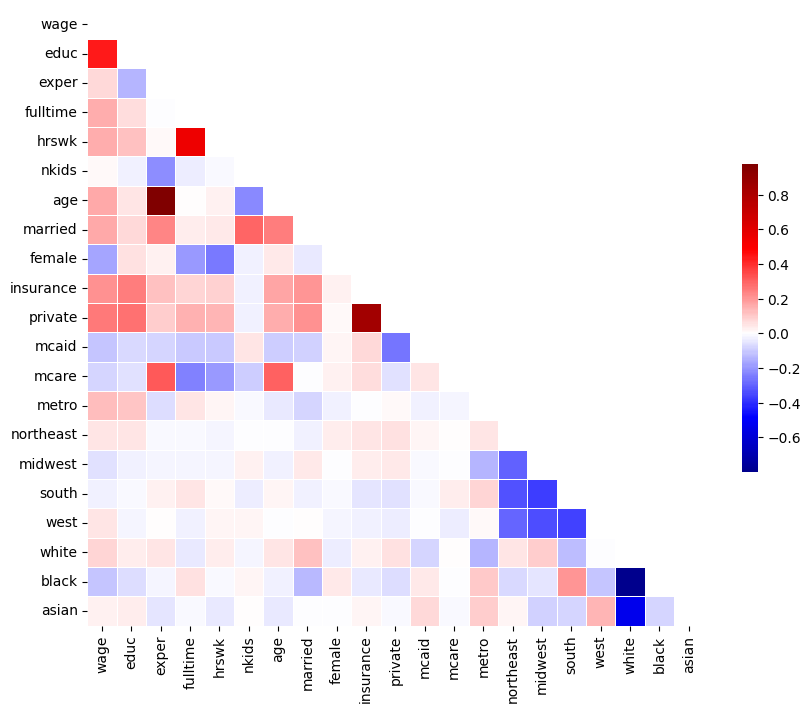

In [ ]:
correlaciones = Train.corr()
mask = np.triu(np.ones_like(correlaciones,dtype = bool))
plt.subplots(figsize=(10,8))
sns.heatmap(correlaciones, mask = mask, cmap="seismic",center = 0, square=True,linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:

def subset_check(l, names):
  if(len(l) == len(names)):
    first = True
    q = ""
    for num, name in zip(l, names):
      if first:
        first = False
        q = q+ f"{name} == {num}"
      else:
        q = q+ f" and {name} == {num}"

    instancia =Train.query(q).shape[0]
    print("La configuracion", l, "para", names, "tiene:", instancia,"instancias")
  else:
    l.append(0)
    subset_check(l,names)
    l.pop()
    l.append(1)
    subset_check(l,names)
    l.pop()

subset_check([],["black","white","asian"])
print()
subset_check([],["northeast","midwest","south","west"])

La configuracion [0, 0, 0] para ['black', 'white', 'asian'] tiene: 0 instancias
La configuracion [0, 0, 1] para ['black', 'white', 'asian'] tiene: 168 instancias
La configuracion [0, 1, 0] para ['black', 'white', 'asian'] tiene: 2871 instancias
La configuracion [0, 1, 1] para ['black', 'white', 'asian'] tiene: 0 instancias
La configuracion [1, 0, 0] para ['black', 'white', 'asian'] tiene: 347 instancias
La configuracion [1, 0, 1] para ['black', 'white', 'asian'] tiene: 0 instancias
La configuracion [1, 1, 0] para ['black', 'white', 'asian'] tiene: 0 instancias
La configuracion [1, 1, 1] para ['black', 'white', 'asian'] tiene: 0 instancias

La configuracion [0, 0, 0, 0] para ['northeast', 'midwest', 'south', 'west'] tiene: 0 instancias
La configuracion [0, 0, 0, 1] para ['northeast', 'midwest', 'south', 'west'] tiene: 838 instancias
La configuracion [0, 0, 1, 0] para ['northeast', 'midwest', 'south', 'west'] tiene: 980 instancias
La configuracion [0, 0, 1, 1] para ['northeast', 'midwest

Podemos ver para las variables *black*, *white* y*asian* solo una de ellas está a 1 en cada instancia. Este también pasa con *northeast*,*midwest*,*south* y *west*.Es por esta, razón que llegamos a ver ciertas correlaciones entre las variables mencionadas. Por lo tanto, podemos aplicar la misma técnica que hace one-hot encoding y eliminar una variable de cada subconjunto mencionado.

Por el resto de variables no llegamos a encontrar correlaciones entre si (quitando de la correlación entre *edad* y *experiencia*)

In [ ]:
Train=Train.drop(columns=["asian","west"])
Test = Test.drop(columns=["asian","west"])

A continuación haremos un estudio de las variables no discretas respecto a la variable objetivo.

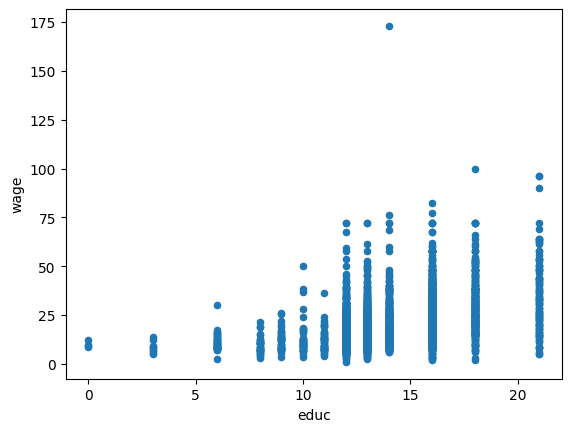

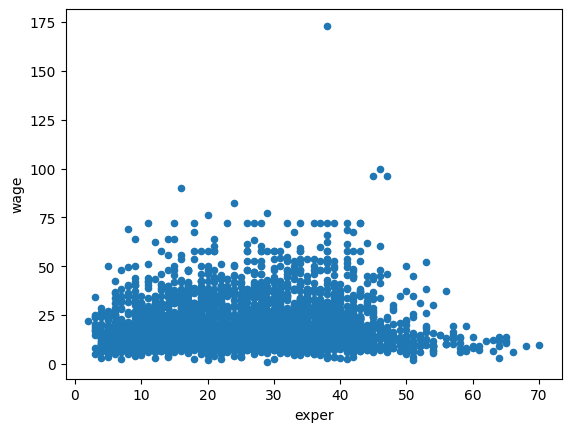

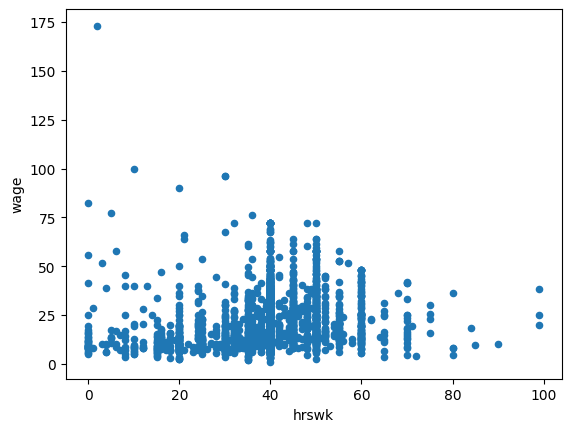

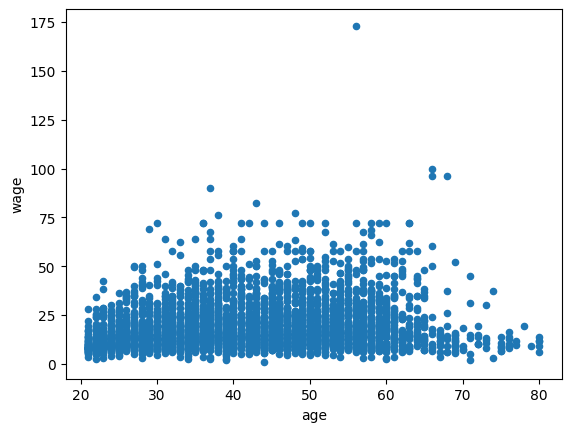

In [ ]:
y = "wage"
l = ["educ","exper","hrswk","age"]
for i in l:
  _=Train.plot.scatter(i,y)

Podemos ver que el nivel de educación respecto a la variable objetivo si que llega a presentar una tendencía más o menos lineal respecto.

En cambio, la experiencia no llega a ser un facto realemente importante sobre la variable objetivo.

Por otra parte de las horas trabajadas semanalmente podemos ver una cierta distribución normal centrada sobre las 40 horas semanales. Por lo tanto podemos decir que el salario si llega a tener una tenedencia directamente proporcional a las horas siempre y cuando se trabajen 40 horas o menos, pero con el caso contrario donde se trabajan más horas, no llega a presentar una tendencia proporcional.

Por último, podemos ver que la edad durante los primeros años de trabajo (los 20 primeros) si que llega a importar. Debido a que son años donde la gente normalmente suben de puestos y no hay un cierto establecimiento en el puesto. A partir de los 40 años vemos que los sueldo se mantienen estables, dando a entender que se está en una edad donde se busca una cierta estabilidad más que un crecimiento laboral de manera economica. Ya a partir de los 60 años vemos como se llega a ganar menos. Posibles causas pueden ser la jubilación donde es común que se reciba una pensión inferior al sueldo cuando se trabajaba, entre otros factores que pueden influir.

A continuación aplicaremos un escalado MinMax a estas variables.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
_=scaler.fit(Train.loc[:,l])
Train.loc[:,l] = scaler.transform(Train.loc[:,l])
Test.loc[:,l] = scaler.transform(Test.loc[:,l])

In [ ]:
X_train = Train.iloc[:,1:]
y_train = Train["wage"]

X_test = Test.iloc[:,1:]
y_test = Test["wage"]


##Apartado B:

In [ ]:
from keras.optimizers import Adam
model = keras.Sequential()
model.add(keras.Input(shape=(X_train.shape[1])))
model.add(keras.layers.Dense(1, activation='linear',
kernel_regularizer='l2'))
model.compile(loss='mean_squared_error', optimizer=Adam(),
metrics='mean_squared_error')
model.fit(X_train, y_train, batch_size=64, epochs=150, verbose=0)

In [ ]:
from sklearn.metrics import mean_squared_error

prediction = model.predict(X_test,verbose=0)

MSE = mean_squared_error(y_test,prediction)
print("Mean Squared Error sobre el conjunto de test:", MSE)

Mean Squared Error sobre el conjunto de test: 133.58932734976975


Podemos ver que el MSE es muy alto. Aunque, con este estadístico no podemos hacer una estimación de la calidad. Principalmente, nos ayudará a modo de comparación con otros modelos.

In [ ]:

models = []

for neurons in np.logspace(5,10,base=2, num=6,dtype=int):

  print(f"Modelo con {neurons} neuronas")
  model = keras.Sequential()
  model.add(keras.Input(shape=(X_train.shape[1])))
  model.add(keras.layers.Dense(neurons, activation='relu',
  kernel_regularizer='l2'))
  model.add(keras.layers.Dense(neurons//2, activation='relu',
  kernel_regularizer='l2'))
  model.add(keras.layers.Dense(1, activation='linear',
  kernel_regularizer='l2'))
  model.compile(loss='mean_squared_error', optimizer=Adam(),
  metrics='mean_squared_error')
  _=model.fit(X_train, y_train, batch_size=64, epochs=150, verbose=0)

  models.append(model)

Modelo con 32 neuronas
Modelo con 64 neuronas
Modelo con 128 neuronas
Modelo con 256 neuronas
Modelo con 512 neuronas
Modelo con 1024 neuronas


In [ ]:

for model,  neurons in zip(models, np.logspace(5,10,base=2, num=6,dtype=int)):
  prediction = model.predict(X_test,verbose=0)
  MSE = mean_squared_error(y_test,prediction)
  print(f"Mean Squared Error sobre el conjunto de test con {neurons} neuronas", MSE)

Mean Squared Error sobre el conjunto de test con 32 neuronas 111.01380691012847
Mean Squared Error sobre el conjunto de test con 64 neuronas 107.38546299893987
Mean Squared Error sobre el conjunto de test con 128 neuronas 109.52574058938552
Mean Squared Error sobre el conjunto de test con 256 neuronas 111.82186874398295
Mean Squared Error sobre el conjunto de test con 512 neuronas 119.386019625676
Mean Squared Error sobre el conjunto de test con 1024 neuronas 123.03270177938042


Vemos que con modelos con una cantidad pequeña de neuronas, el uso de los diferentes activadores no cambia substancialemente el error. En cambia tamaños grandes, es importante una buena elección de los hiperparametros (pudiendo reducir de manera considerable el error).

A continuació contestaremos las preguntas del apartado b.

**¿Se obtiene un mejor resultado que con el
perceptrón monocapa?**

Podemos ver que todos los modelos tienen un MSE inferior al perceptrón monocapa. Dando a entender que todos presentan un error inferior al modelo inicial. Por lo tanto, dan un resultado mejor.

**¿Aumentar el número de neuronas mejora el resultado?**

No, como podemos observar aumentando de 32 a 256  neuronas(en los casos de relu en ambas capas) no llegamos a ver un aumento considerable . A partir de este momento, el aumento de neuronas comparte una disminución del rendimiento respecto a modelos anteriores.


Como podemos observar, la mejor red tiene 64 neuronas en la primera capa y 32 en la segunda. Por lo tanto, haremos un estudio de los valores predichos y sus errores, respecto a los valores reales.

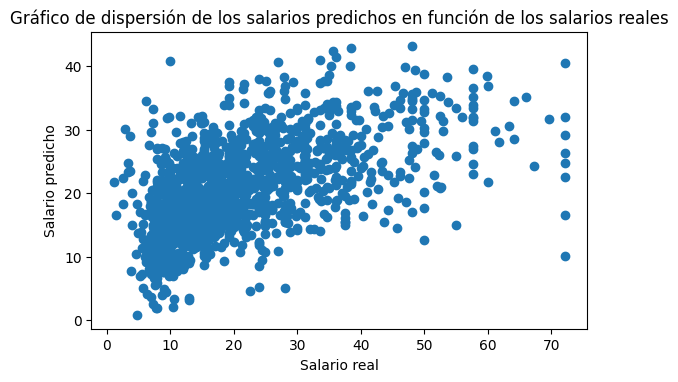

In [ ]:
best_model = models[1]
prediction = models[1].predict(X_test,verbose=0)
_=plt.scatter(y_test,prediction)
_=plt.xlabel('Salario real')
_=plt.ylabel('Salario predicho')
_=plt.title('Gráfico de dispersión de los salarios predichos en función de los salarios reales')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
_=plt.draw()

Podemos observar una cierta tendencia logaritmica de los datos predichos en función de los valores reales, esto nos sugiere que los hiperparametros de activación de las capas no han sido escogidos adequadamente. Vemos que a salarios más grandes pero predicción llega a hacer (todo esto debido a que la diferencia entre salario real y predicho cada vez es más grande cuando el valor predicho es un logaritmo del valor real).

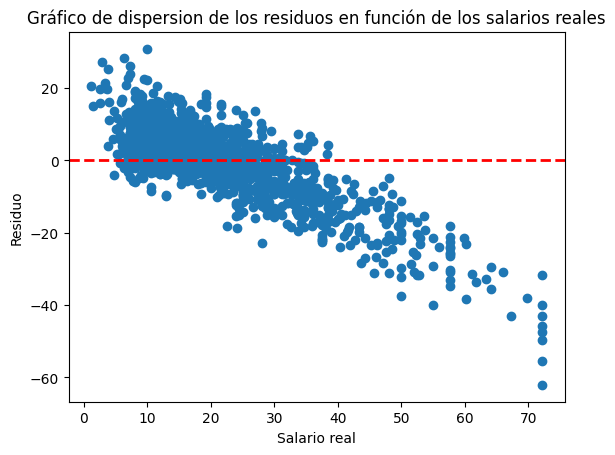

In [ ]:

residuals = prediction.flatten() -y_test
_=plt.scatter(y_test, residuals)
_=plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
_=plt.title('Gráfico de dispersion de los residuos en función de los salarios reales')
_=plt.xlabel('Salario real')
_=plt.ylabel('Residuo')
_=plt.show()

Como podemos ver, hay una tendencia lineal en la nube de punto. Esto nos puede llegar a decir que el modelo no ha logrado representar una característica linear que se encuentra en los datos. Es decir, nuestro modelo no es el más indicado para este tipo de datos. Posible, alternativas serían añadir más capas para intentar conseguir capturar esas "características" que se encuentran en los datos y que nuestros modelos de 2 capas no hemos conseguido apreciar.

##Apartado C:

Valores predichos
Valor predicho: 16.93748 valor real:  48.08
Valor predicho: 18.077974 valor real:  18.63
Valor predicho: 18.531822 valor real:  42.0
Valor predicho: 20.072367 valor real:  24.05
Valor predicho: 20.197012 valor real:  17.5
Valor predicho: 14.625334 valor real:  22.25
Valor predicho: 14.481281 valor real:  11.0
Valor predicho: 21.774914 valor real:  40.88
Valor predicho: 16.614105 valor real:  29.08
Valor predicho: 21.666977 valor real:  9.45
Valor predicho: 11.042533 valor real:  12.5
Valor predicho: 17.811703 valor real:  13.0
Valor predicho: 18.956182 valor real:  19.24
Valor predicho: 20.030226 valor real:  35.0
Valor predicho: 19.332998 valor real:  16.83
Valor predicho: 16.13469 valor real:  9.23
Valor predicho: 16.710827 valor real:  15.0
Valor predicho: 20.012506 valor real:  16.83
Valor predicho: 17.523104 valor real:  10.58
Valor predicho: 11.641519 valor real:  12.16
Valor predicho: 16.581106 valor real:  13.0
Valor predicho: 18.887722 valor real:  24.58
Valo

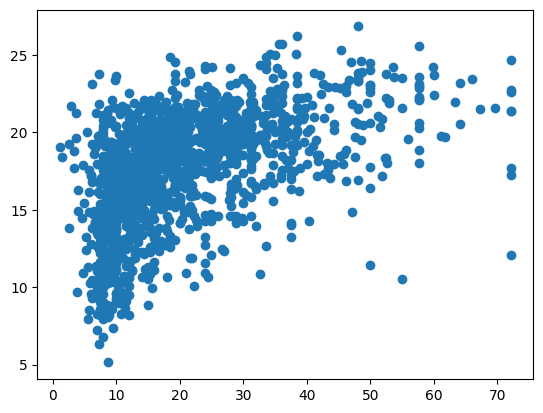

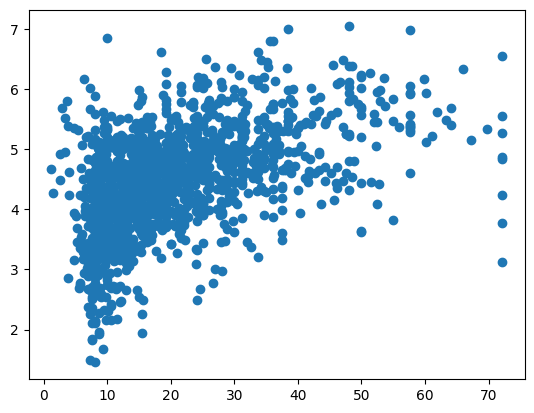

In [ ]:
from keras.optimizers import Adam

def nllike(y,y_hat):
  mean, logvar = tf.split(y_hat,2, -1)
  square = tf.square(mean - y)
  sigsq = tf.add(tf.exp(logvar),1e-3)
  ms = tf.add(tf.divide(square,sigsq), logvar)
  return tf.reduce_mean(ms)

neurons = 32
input = keras.Input(shape=(X_train.shape[1]))
net = keras.layers.Dense(neurons, activation='relu', kernel_regularizer='l2')(input)
output1 = keras.layers.Dense(neurons//2, activation='relu', kernel_regularizer='l2')(net)
output1 = keras.layers.Dense(1, activation="linear", kernel_regularizer='l2')(output1)
output2 = keras.layers.Dense(neurons//2, activation='relu', kernel_regularizer='l2')(net)
output2 = keras.layers.Dense(1, activation='linear', kernel_regularizer='l2')(output2)
cout = keras.layers.Concatenate(axis=-1)([output1, output2])
model = keras.Model(inputs=input, outputs=cout)
model.compile(loss=nllike, optimizer=Adam(), metrics=nllike)

_=model.fit(X_train, y_train, batch_size=64, epochs=150, verbose=0)

prediction = model.predict(X_test,verbose=0)
print("Valores predichos")
for i, y_real,_ in zip(prediction,y_test, range(0,100)): print("Valor predicho:",i[0],"valor real: ", y_real)
_=plt.figure()
_=plt.scatter(y_test,prediction[:,0],label='Column 0')
_=plt.show()
_=plt.figure()
_=plt.scatter(y_test,prediction[:,1],label='Column 1')
_=plt.show()

In [ ]:
print("Media del conjunto de train:",y_train.mean())
print("Logaritmo de la varianza del conjunto de train:",np.log(y_train.var()))

Media del conjunto de train: 19.925029533372708
Logaritmo de la varianza del conjunto de train: 5.051050925453941


Viendo los valores predichos, vemos una cierta similitud con la media de salarios y su respectivo logaritmo de la varianza. Esto se puede ver haciendo una comparación de los valores predichos con la media y el logaritmo de la varianza sobre la variable objetivo del conjunto de train representado en la sección anterior(los valores predichos son similares a los valores calculados en el apartado anterior). Aun así, hay cierta diversidad de valores. Por lo tanto, esta red predice el salario teniendo en cuenta una cierta incertidumbre. Estamos entrenando un modelo probabilístico.

Estos valores están presentes en la formula del negativo logaritmo de la verosimilitud de la distribución gaussiana con la matriz de covarianza siendo una diagonal (esto significa que asumimos que no hay correlaciones entre variables, justo como en nuestro caso donde no se llegan a ver grandes correlaciones entre variables):

$$
NLL(\mathbf{Y}, \mathbf{X}, \mathbf{w}) = \frac{1}{2} \sum_{i=1}^{n} \left( \frac{(y_i - w^\top x_i)^2}{\sigma^2} + \log(\sigma^2) \right) + \frac{n}{2} \log(2 \pi)
$$

En nuestro caso nos interesa optimizar el primer termino(concretamente lo que hay dentro del primer sumatorio). En nuestro caso la variable mean corresponde $ w^\top x_i $ y logvar corresponde $\log{σ^2}$ que en nuestro caso nos interesa $σ^2$ y por eso hacemos su exponenciación. Por lo tanto, la variable square es el calculo $(y_i - w^\top x_i)^2$, sigsq es el calculo $\sigma^2$ y por último el calculo total de ms es $\frac{(y_i - w^\top x_i)^2}{\sigma^2} + \log(\sigma^2)$ .

A continuación haremos una exploración del hiperparametro de neuronas.

In [ ]:
models = []
for neurons in np.logspace(5,10,base=2, num=6,dtype=int):
  print(f"Modelo con {neurons} neuronas")
  input = keras.Input(shape=(X_train.shape[1]))
  net = keras.layers.Dense(neurons, activation='relu', kernel_regularizer='l2')(input)
  output1 = keras.layers.Dense(neurons//2, activation='relu', kernel_regularizer='l2')(net)
  output1 = keras.layers.Dense(1, activation="linear", kernel_regularizer='l2')(output1)
  output2 = keras.layers.Dense(neurons//2, activation='relu', kernel_regularizer='l2')(net)
  output2 = keras.layers.Dense(1, activation='linear', kernel_regularizer='l2')(output2)
  cout = keras.layers.Concatenate(axis=-1)([output1, output2])
  model = keras.Model(inputs=input, outputs=cout)
  model.compile(loss=nllike, optimizer=Adam(), metrics=nllike)
  _=model.fit(X_train, y_train, batch_size=64, epochs=150, verbose=0)
  models.append(model)

Modelo con 32 neuronas
Modelo con 64 neuronas
Modelo con 128 neuronas
Modelo con 256 neuronas
Modelo con 512 neuronas
Modelo con 1024 neuronas


In [ ]:
for neurons, model in zip(np.logspace(5,10,base=2, num=6,dtype=int),models):
  prediction = model.predict(X_test,verbose=0)
  MSE = mean_squared_error(y_test,prediction[:,0])
  print(f"MSE sobre el conjunto de test y con el modelo de {neurons} nueronas", MSE)

MSE sobre el conjunto de test y con el modelo de 32 nueronas 133.33157531996218
MSE sobre el conjunto de test y con el modelo de 64 nueronas 135.76687771775735
MSE sobre el conjunto de test y con el modelo de 128 nueronas 133.564349456794
MSE sobre el conjunto de test y con el modelo de 256 nueronas 130.84242074598626
MSE sobre el conjunto de test y con el modelo de 512 nueronas 126.48583552939625
MSE sobre el conjunto de test y con el modelo de 1024 nueronas 131.86535705785028


Vemos que el mejor modelo tiene 512 neuronas en la capa net. Entonces ahora haremos una comparación con el mejor modelo entrenado hasta ahora.

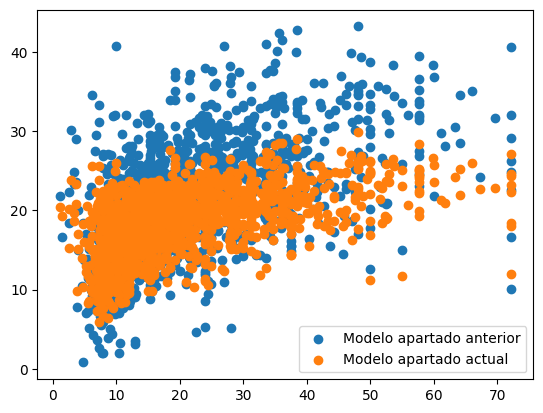

In [ ]:
prediction = best_model.predict(X_test,verbose=0)
prediction2 = models[4].predict(X_test,verbose=0)
_=plt.figure()
_=plt.scatter(y_test,prediction, label="Modelo apartado anterior")
_=plt.scatter(y_test,prediction2[:,0], label="Modelo apartado actual")
_=plt.legend()
_=plt.show()

Viendo una comparación de los valores predichos de cada modelo respecto con los valores reales. Podemos ver que los valores no llegan a estar tan dispersos y esto es debido a que la red actual intenta predecir el valor alrededor de un punto. Utiliza la varianza que se va calculando durante el aprendizaje y el valor predicho. Esto puede ser beneficioso ya puede ayudar a controlar todo el tema prediciones que den valores anormales o no cercanos al valor real.

## Apartado D:

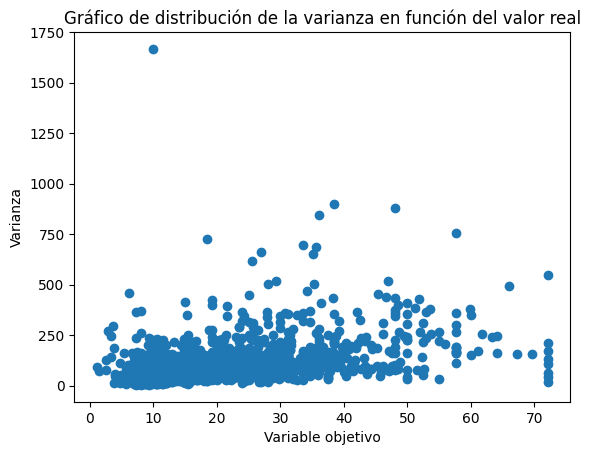

(10, 20]     568
(0, 10]      306
(20, 30]     303
(30, 40]     157
(40, 50]      70
(50, 60]      30
(60, 70]      10
(70, 80]       8
(80, 90]       0
(90, 100]      0
Name: wage, dtype: int64

In [ ]:
var = np.exp(prediction2[:,1])
_=plt.figure()
_=plt.scatter(y_test,var, label="Modelo apartado actual")
_=plt.xlabel("Variable objetivo")
_=plt.ylabel("Varianza")
_=plt.title("Gráfico de distribución de la varianza en función del valor real")
_=plt.show()
bins = pd.cut(y_test,[0,10,20,30,40,50,60,70,80,90,100])
bins.value_counts(sort=True)

Vemos que la varianza se concentra en el rango de valores 0-40 respecto al eje x y entre 0 y 250 en el eje de y. Esto nos llega a decir que no hay una gran diferencia entre las predicciones de la varianza para valores pequeños de salarios. En cambio, para valores superiores a 50, la varianza predicha tiene una mayor diversidad de valores. Esto puede ser debido a las pocas instancias que hay para poder predecir estos valores. Arriba se muestra el conteo de valores en y_Test separado en bins, como podemos ver solo 118 instancias tienen un salario superior a 40.

<Figure size 10000x6000 with 0 Axes>

<ErrorbarContainer object of 3 artists>

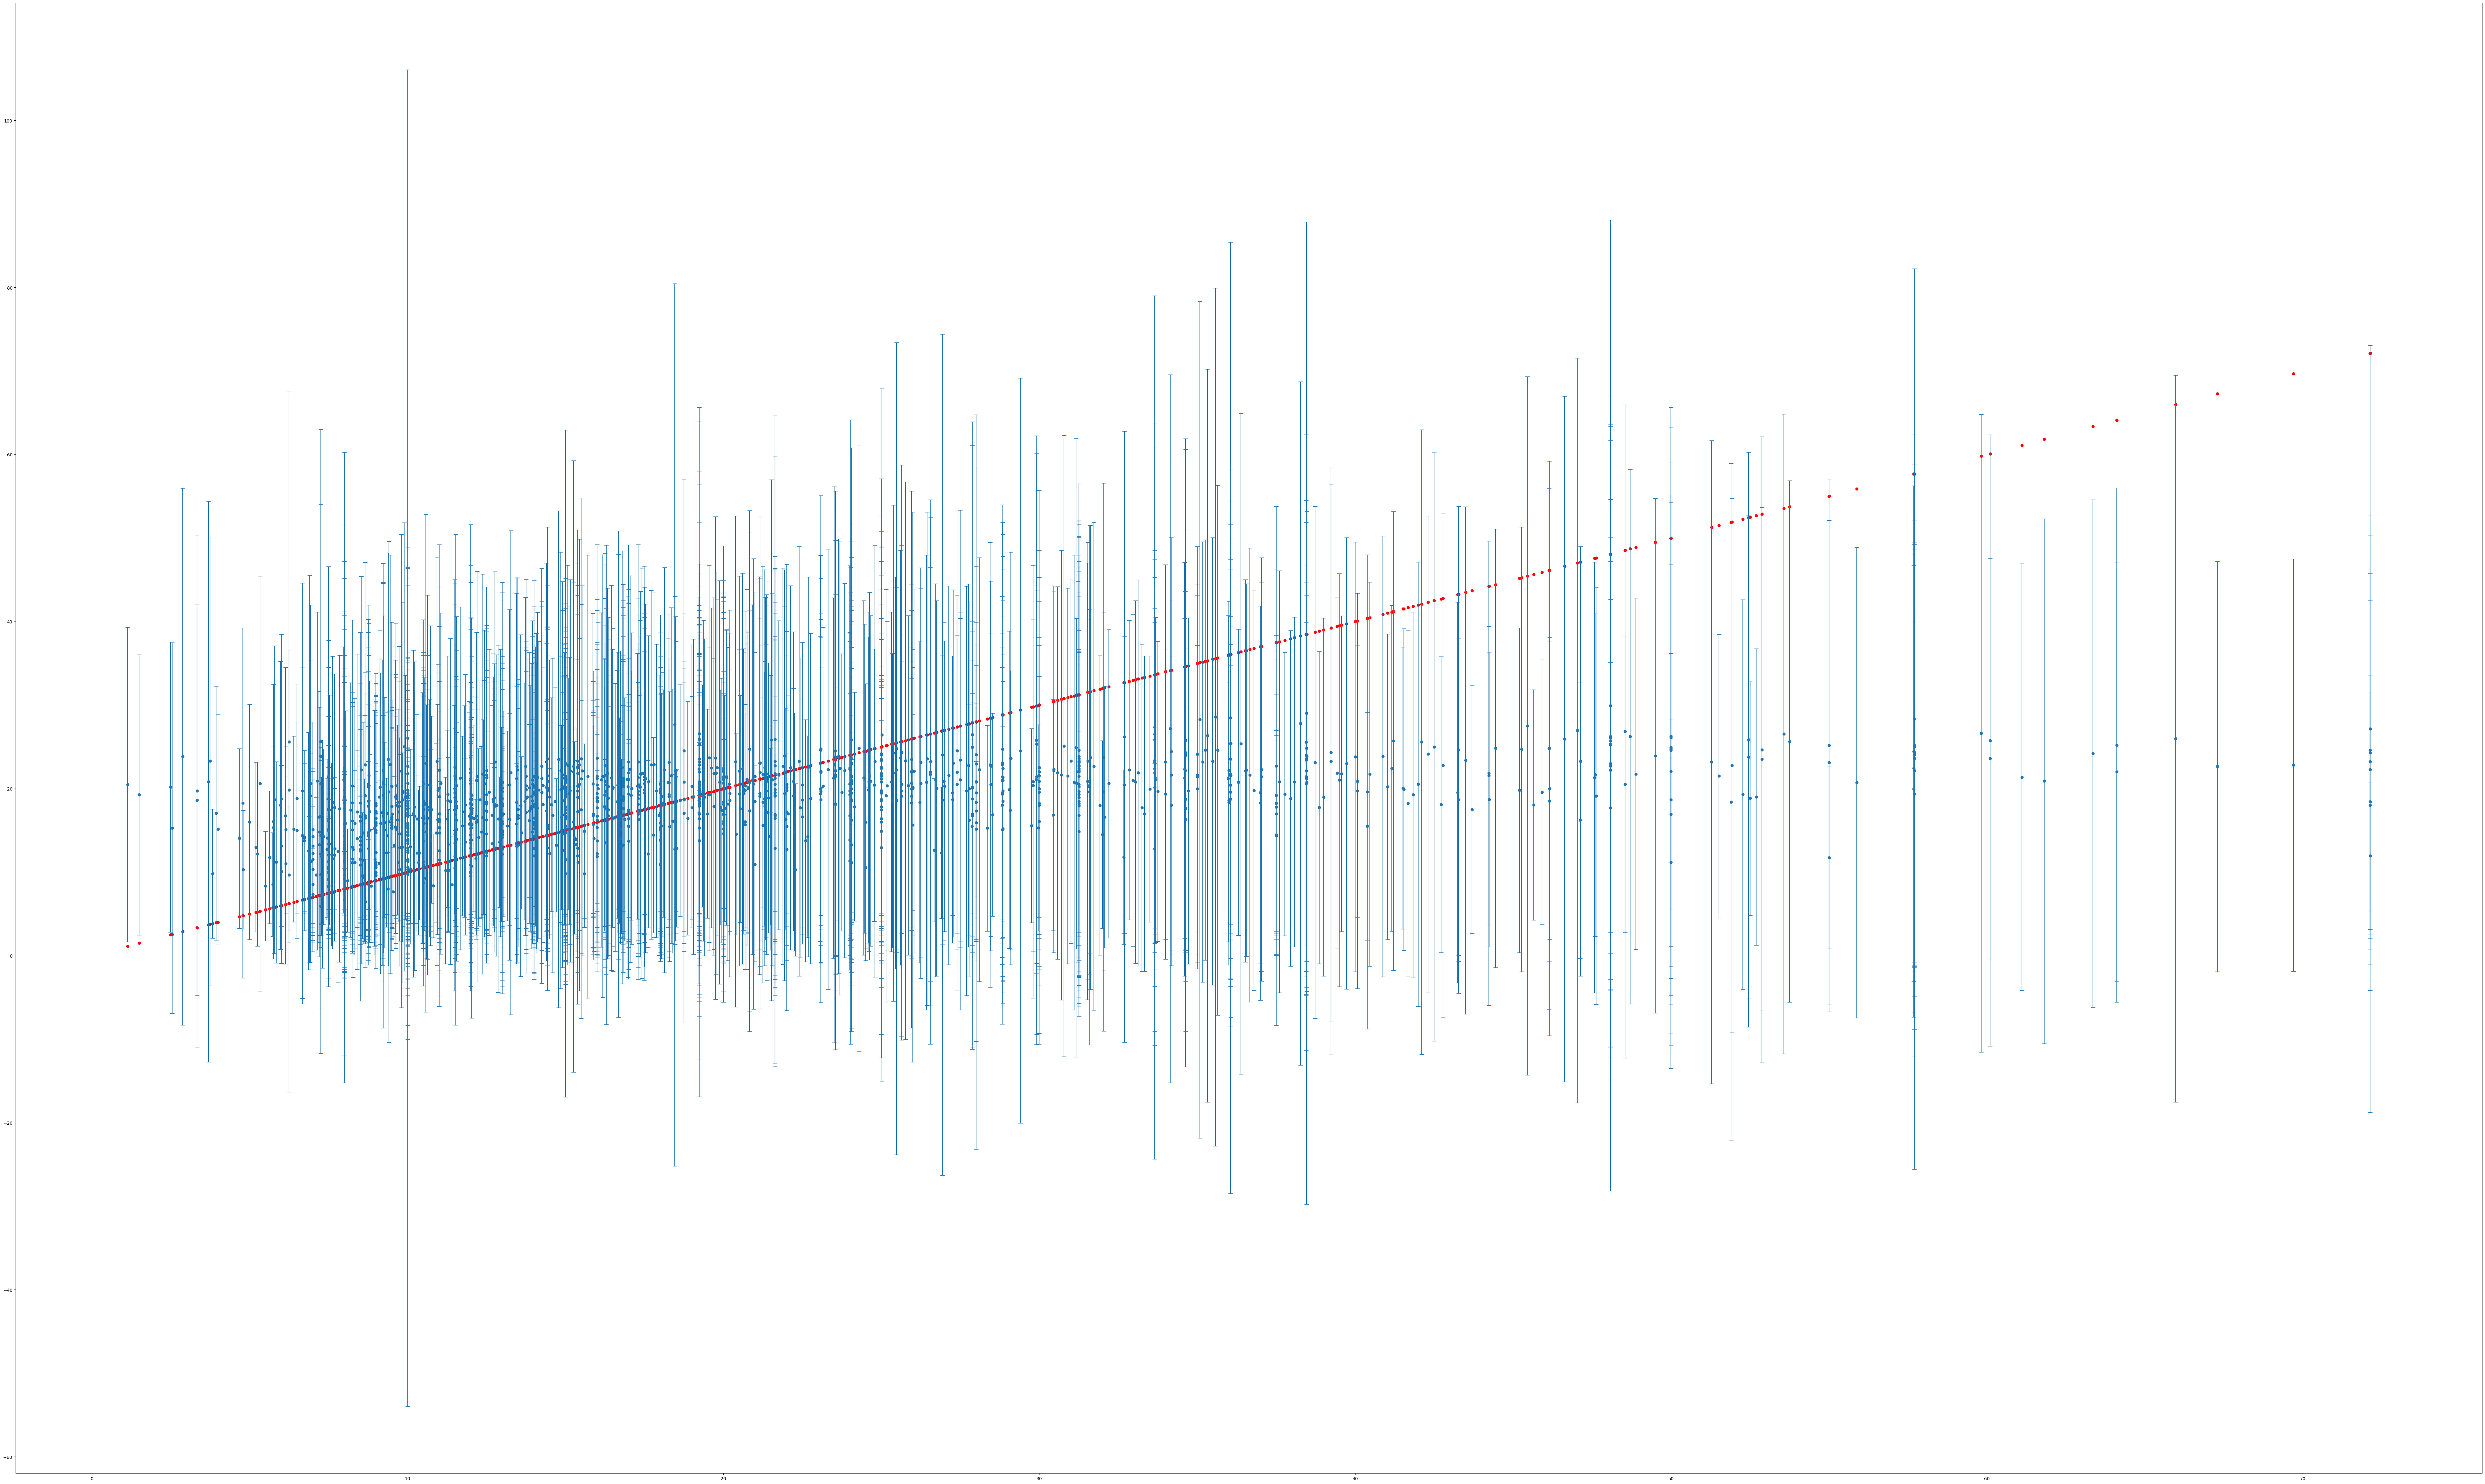

In [ ]:
plt.figure(figsize=(100, 60))
plt.scatter(y_test, y_test, color='red', label='Actual Values')
plt.errorbar(y_test, prediction2[:,0], yerr=1.96 * np.sqrt(var), fmt='o', capsize=5, label='Predicted Variance')
plt.show()

Podemos decir que entonces, que la relación de la varianza y la variable objetivo se basa en intervalos de confianza.
- El valor predicho sería el valor central del intervalo
- La varianza establece los limites del intervalo.
- El valor real se entiende que debe de estar entre el intervalo propuesto.

Un ejemplo se puede ver en la imagen anterior donde hemos hecho un intervalo del 95% de  confianza con todos los valores predichos y su varianza (en este caso utilizamos la desviación típica). Podemos ver que gran parte los valores reales estan dentro de sus respectivos intervalos.

Entonces NLL lo que intenta es acotar cada vez más estos intervalos y dar  una predicción mejor de los valores.